In [1]:
from __future__ import division
import os
import sys
import copy
import numpy as np
from numpy import ma
import math as m
import pandas as pd
import matplotlib.patches as mpatches
import string

import pickle
from numpy import genfromtxt
from scipy.interpolate import griddata
from matplotlib import rc
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

import datetime
from matplotlib.dates import DayLocator, MonthLocator, HourLocator, AutoDateLocator, DateFormatter, drange
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator
from numpy import arange
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.cm as cm
import matplotlib.mlab as mlab

import glob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [8]:
# Font / Figure Size
import matplotlib.pylab as pylab
params = {'legend.fontsize': '7',
         'axes.labelsize': '7',
         'axes.titlesize': '7',
         'xtick.labelsize': '7',
         'ytick.labelsize': '7',
          
         'xtick.major.pad': '7',
         'ytick.major.pad': '7',
         'axes.titlepad': 10,
         'axes.labelpad': 15,
         
         'font.sans-serif':'Avenir',
         
         'axes.linewidth': 0.5,
         'xtick.major.width': 0.5,
         'ytick.major.width': 0.5}
pylab.rcParams.update(params)

In [3]:
# Custom Colors

darkblue = '#4e79a7'
orange = '#f28e2b'
red = '#e15759'
lightblue = '#76b7b2'
green = '#59a14f'
yellow = '#edc948'
purple = '#b07aa1'
pink = '#ff9da7'
brown = '#9c755f'
gray = '#bab0ac'

In [4]:
from extract_data_sep_power import get_data_sep_power
from extract_data_one_power import get_data_one_power
from extract_data_non_sep_power import get_data_non_sep_power

In [5]:
def cost_conts(ax, path, x_labels, colors):
    dic = {}
    solar_cost = np.empty(len(x_labels))
    wind_cost = np.empty(len(x_labels))
    batt_cost = np.empty(len(x_labels))
    storage_x_cost = np.empty(len(x_labels))
    pgp_cost = np.empty(len(x_labels))
    
    for i, x_label in enumerate(x_labels):
        #print(path)
        #print(x_label)
        if x_label == '':
            solar_cost[i] = 0
            wind_cost[i] = 0
            pgp_cost[i] = 0
            storage_x_cost[i] = 0
            batt_cost[i] = 0
            continue
        elif x_label == 'Metal-Air':
            dic[x_label] = get_data_non_sep_power(path + '/' + x_label, 2, 'fixed_cost', 3, 'fixed_cost', False)
        elif x_label == 'CAES':
            dic[x_label] = get_data_sep_power(path + '/' + x_label, 2, 'fixed_cost', 3, 'fixed_cost', False)
        else:
            dic[x_label] = get_data_one_power(path + '/' + x_label, 2, 'fixed_cost', 3, 'fixed_cost', False)
    
        #print(dic[x_label]['system_cost'][0])
        
        solar_cost[i] = dic[x_label]['solar_cost'][0]
        wind_cost[i] = dic[x_label]['wind_cost'][0]
        pgp_cost[i] = dic[x_label]['pgp_cost'][0]
        storage_x_cost[i] = dic[x_label]['third_tech_cost'][0]
        batt_cost[i] = dic[x_label]['batt_cost'][0]
    
    w=0.8
    ax.bar(x_labels, solar_cost, label='Solar', color=yellow, width=w)
    ax.bar(x_labels, wind_cost, bottom=solar_cost, label='Wind', color='cornflowerblue', width=w)
    ax.bar(x_labels, pgp_cost, bottom=solar_cost+wind_cost, label='Hydrogen', color=pink, width=w)
    ax.bar(x_labels, storage_x_cost, bottom=solar_cost+wind_cost+pgp_cost, label='Storage X', color=colors, width=w)
    ax.bar(x_labels, batt_cost, bottom=solar_cost+wind_cost+pgp_cost+storage_x_cost, label='Li-ion', color=purple, width=w)
    

    plt.xticks(rotation=90)   

/var/folders/_n/__95sd_157z4_g0kbd99cm1m0000gn/T/ipykernel_4932/1001312731.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=1, rowspan=1)
/var/folders/_n/__95sd_157z4_g0kbd99cm1m0000gn/T/ipykernel_4932/1001312731.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Li-ion', 'RFB', 'Gravity', 'PSH', 'CAES', 'Thermal', 'Metal-Air', 'Hydrogen'])
/var/folders/_n/__95sd_157z4_g0kbd99cm1m0000gn/T/ipykernel_4932/1001312731.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['Li-ion + RFB', '+ Gravity', '+ PSH', '+ CAES', '+ Thermal', '+ Metal-Air', '+ Hydrogen'])
/var/folders/_n/__95sd_157z4_g0kbd99cm1m0000gn/T/ipykernel_4932/1001312731.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is depr

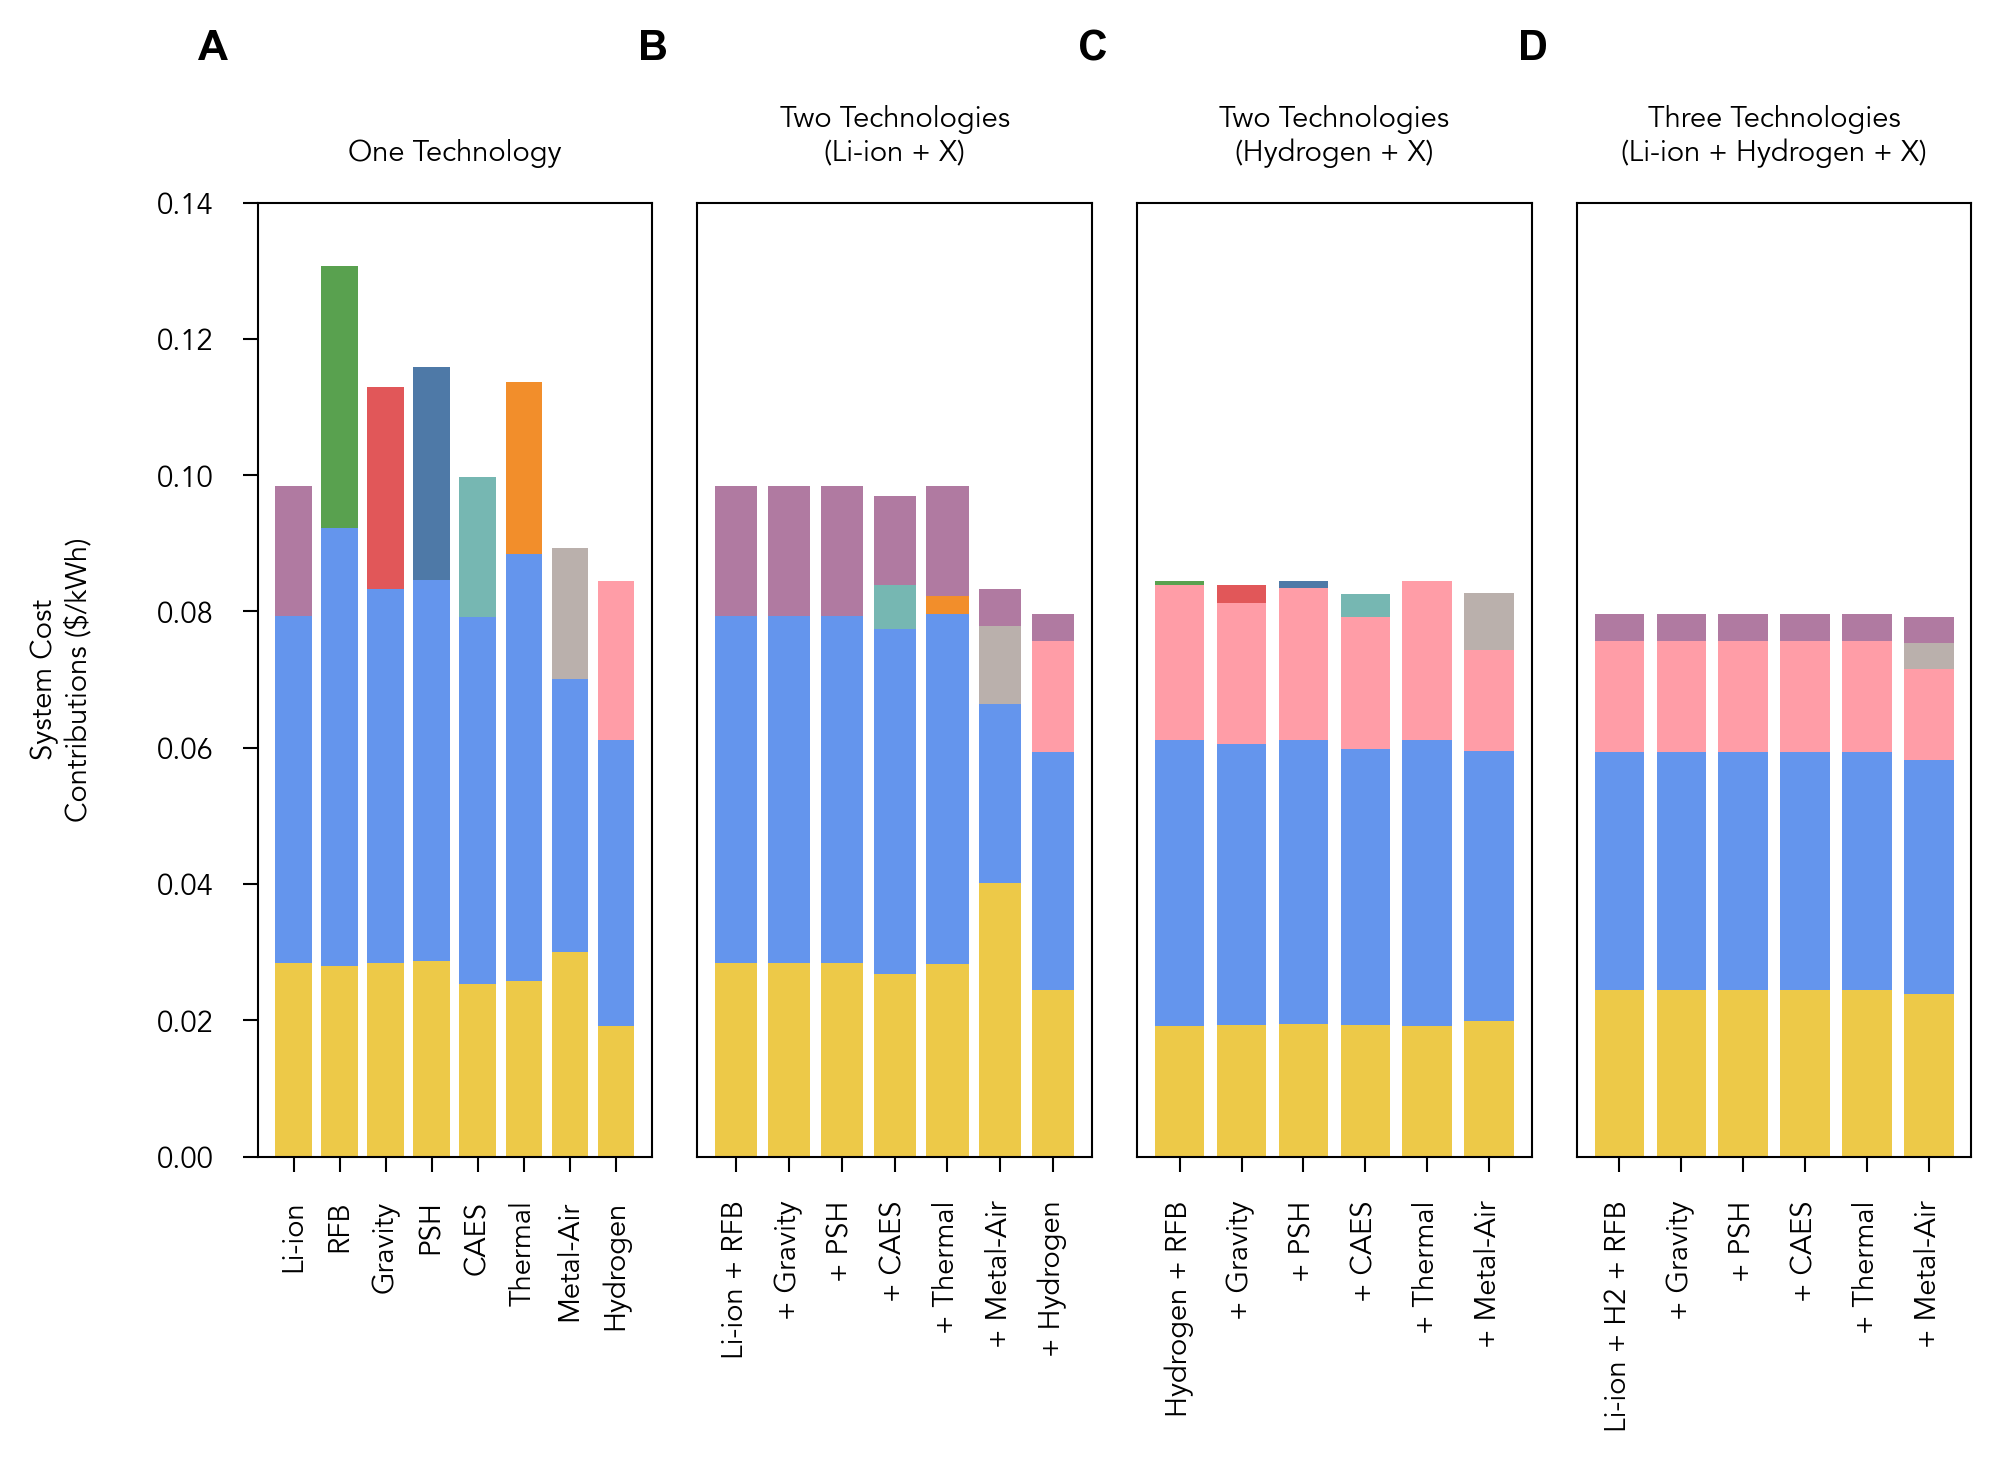

In [28]:
output_data_path = '../Output_Data/CONUS/'
Li_ion_PGP_X_directory = os.path.join(output_data_path, 'Low_Li-ion/Li-ion_PGP_X')
PGP_X_directory = os.path.join(output_data_path, 'Two_Techs_PGP_X')
Li_ion_X_directory = os.path.join(output_data_path, 'Low_Li-ion/Li-ion_X')

# Set up techs
storage_names = ['Low_Li-ion', 'RFB', 'Gravitational', 'PSH', 'CAES', 'Thermal', 'Metal-Air', 'Hydrogen']
storage_colors= [purple, green, red, darkblue, lightblue, orange, gray, pink]

Li_ion_PGP_X_techs = [tech for tech in storage_names if tech != 'Low_Li-ion' and tech != 'Hydrogen']
PGP_X_techs = Li_ion_PGP_X_techs
Li_ion_X_techs = Li_ion_PGP_X_techs + ['Li-ion_PGP']

storage_x_colors = ['white', green, red, darkblue, lightblue, orange, gray]

# Just Storage X

X_directory = '../Output_Data/CONUS/One_Tech_X'
# Replace in storage_names Hydrogen with PGP
X_techs = [tech for tech in storage_names if tech != 'Hydrogen'] + ['PGP']

# Plot Figure

mm = 1/25.4 # millimeters in inches
fig_w = 172*mm
fig_h = 120*mm
fig = plt.subplots(nrows=1,ncols=2, figsize=(fig_w,fig_h), dpi=300)

########################################################################################
#         X : Cost Contributions of Different Storage X Techs (One technology)           #
########################################################################################

ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=1, rowspan=1)

ax1.set_title('One Technology')
ax1.set_ylabel('System Cost\nContributions ($/kWh)')
xtick_names = ['Li-ion'] + [tech for tech in storage_names if tech != 'Low_Li-ion']
ax1.set_xticklabels(['Li-ion', 'RFB', 'Gravity', 'PSH', 'CAES', 'Thermal', 'Metal-Air', 'Hydrogen'])
cost_conts(ax1, X_directory, X_techs, storage_x_colors)

###############################################################################
#         Li-ion + X: Cost Contributions of Different Storage X Techs (Two technologies)           #
###############################################################################

ax2 = plt.subplot2grid((1, 4), (0, 1), colspan=1, rowspan=1)

ax2.set_title('Two Technologies\n(Li-ion + X)')
ax2.set_xticklabels(['Li-ion + RFB', '+ Gravity', '+ PSH', '+ CAES', '+ Thermal', '+ Metal-Air', '+ Hydrogen'])
cost_conts(ax2, Li_ion_X_directory, Li_ion_X_techs, [c for c in storage_x_colors if c != 'white'])


###############################################################################
#         PGP + X or Li-ion + X: Cost Contributions of Different Storage X Techs (Two technologies)           #
###############################################################################

ax3 = plt.subplot2grid((1, 4), (0, 2), colspan=1, rowspan=1)

ax3.set_title('Two Technologies\n(Hydrogen + X)')
ax3.set_xticklabels(['Hydrogen + RFB', '+ Gravity', '+ PSH', '+ CAES', '+ Thermal', '+ Metal-Air'])
cost_conts(ax3, PGP_X_directory, PGP_X_techs, [c for c in storage_x_colors if c != 'white'])

####################################################################################
#        PGP + Li-ion + X: Cost Contributions of Different Storage X Techs (Three Technologies)          #
####################################################################################

ax4 = plt.subplot2grid((1, 4), (0, 3), colspan=1, rowspan=1)

ax4.set_title('Three Technologies\n(Li-ion + Hydrogen + X)')
ax4.set_xticklabels(['Li-ion + H2 + RFB', '+ Gravity', '+ PSH', '+ CAES', '+ Thermal', '+ Metal-Air'])
cost_conts(ax4, Li_ion_PGP_X_directory, Li_ion_PGP_X_techs,  [c for c in storage_x_colors if c != 'white'])
plt.subplots_adjust(wspace=0.35, hspace=0.8)
#####################################################################

# Set x and y lims

ymax = 0.14
ax1.set_ylim(0, ymax)
ax2.set_ylim(0, ymax)
ax3.set_ylim(0, ymax)
ax4.set_ylim(0, ymax)

#####################################################################

#ax1.set_box_aspect(1)
#ax2.set_box_aspect(1)
#ax3.set_box_aspect(1)

ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

plt.tight_layout()

ax1.text(-0.15, 1.15, 'A', transform=ax1.transAxes, fontsize=10, fontweight='bold', name='Arial')
ax2.text(-0.15, 1.15, 'B', transform=ax2.transAxes, fontsize=10, fontweight='bold', name='Arial')
ax3.text(-0.15, 1.15, 'C', transform=ax3.transAxes, fontsize=10, fontweight='bold', name='Arial')
ax4.text(-0.15, 1.15, 'D', transform=ax4.transAxes, fontsize=10, fontweight='bold', name='Arial')

if not os.path.exists('Figures/SI'):
    os.makedirs('Figures/SI')
plt.savefig('Figures/SI/Fig_S9_costs_Low_Li_ion.png', dpi=300, bbox_inches='tight')

In [7]:
# fig = plt.figure(figsize=(5, 1.75))
# ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
# cost_conts(ax, Li_ion_PGP_X_directory, Li_ion_PGP_X_techs, Li_ion_PGP_X_dataframes)
# ax.tick_params(axis='both', which='major', labelsize=13, pad=5)
# ax.set_xticks([])
# ax.set_xlim(-0.5, 6.5)
# ax.set_ylim(0.074, 0.085)

In [8]:
# fig = plt.figure(figsize=(5, 1.75))
# ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
# cost_conts(ax, PGP_X_directory, PGP_X_techs, PGP_X_dataframes)
# ax.tick_params(axis='both', which='major', labelsize=13, pad=5)
# ax.set_xticks([])
# ax.set_xlim(-0.5, 6.5)
# ax.set_ylim(0.074, 0.085)

In [9]:
# df1 = dataframes['PGP']
# df2 = dataframes['RFB']
# df3 = dataframes['PSH']
# df4 = dataframes['Gravitational']
# df5 = dataframes['Thermal']
# df6 = dataframes['CAES']
# df7 = dataframes['Metal-Air']
# pd.concat([df1.set_index(df6.index), df2.set_index(df6.index), 
#            df3.set_index(df6.index), df4.set_index(df6.index),
#            df5.set_index(df6.index), df6.set_index(df6.index),
#            df7.set_index(df6.index)], axis=1)